Importer les bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

Import metadata

In [2]:
# Charger les métadonnées des chansons d'oiseaux
df = pd.read_csv("ouiseau/bird_songs_metadata.csv")
class_names = df["name"].unique()

Récupérer tous les fichiers audio

In [3]:
# Définir le chemin vers les fichiers audio
path_to_wav = "ouiseau/wavfiles/"
datafiles = glob(path_to_wav + "*")

Générer des spectrogrammes

In [4]:
# Fonction pour générer un spectrogramme
def generate_spectrogram(file_audio, identifier):
    audio_data, sample_rate = librosa.load(path_to_wav + file_audio)
    spec_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    spec_mel = librosa.power_to_db(spec_mel, ref=np.max)
    figure, axis = plt.subplots(figsize=(15, 5))
    axis.set_title("Mel Spectrogram")
    plt.suptitle(identifier)
    librosa.display.specshow(spec_mel, x_axis='time', y_axis='log', ax=axis)
    return ipd.Audio(path_to_wav + file_audio, rate=sample_rate)

Traiter les fichiers audio

In [5]:
# Fonction pour traiter un fichier audio
def process_audio(audio_file):
    audio_data, sample_rate = librosa.load(audio_file, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

Générer un DataFrame pour les tests

In [6]:
# Créer un DataFrame pour les données de test
df_train = pd.DataFrame({"name": df["name"], "audiopath": path_to_wav + df["filename"]})

# Générer les spectrogrammes Mel pour chaque fichier audio
df_train["mel_spec"] = df_train["audiopath"].apply(lambda x: process_audio(x))

# Encoder les étiquettes de classe
df_train["class"] = df_train["name"].factorize()[0]

Mélanger les données

In [7]:
# Mélanger les données
df_train = shuffle(df_train)

Séparer les étiquettes des données

In [8]:
# Séparer les données et les étiquettes
(test_x, test_y) = df_train["mel_spec"].values, df_train["class"].values
test_y = to_categorical(test_y, num_classes=len(class_names))
test_x = np.stack(test_x[:])
test_x = tf.keras.utils.normalize(test_x)

# Préparer l'ensemble de test
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_dataset = test_dataset.batch(10)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Importer le modèle

In [9]:
# Charger le modèle sauvegardé
saved_model_path = "modeles/saved_model.keras"
model = load_model(saved_model_path)

Tester le modèle

In [10]:
# Tester le modèle et générer un rapport de classification
from sklearn.metrics import classification_report

model.evaluate(test_dataset, verbose=2)

# Obtenir les prédictions
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)

# Générer un rapport de classification
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

543/543 - 20s - 37ms/step - accuracy: 0.9841 - loss: 0.2363 - precision: 0.9841 - recall: 0.9841
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
                      precision    recall  f1-score   support

       Bewick's Wren       0.99      0.98      0.98       893
Northern Mockingbird       0.98      0.98      0.98      1182
      American Robin       0.99      0.98      0.98      1017
        Song Sparrow       0.98      0.99      0.98      1256
   Northern Cardinal       0.99      0.99      0.99      1074

            accuracy                           0.98      5422
           macro avg       0.98      0.98      0.98      5422
        weighted avg       0.98      0.98      0.98      5422

                      precision    recall  f1-score   support

       Bewick's Wren       0.99      0.98      0.98       893
Northern Mockingbird       0.98      0.98      0.98      1182
      American Robin       0.99      0.98      0.98      1017
        S

Matrice de confusion

543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step


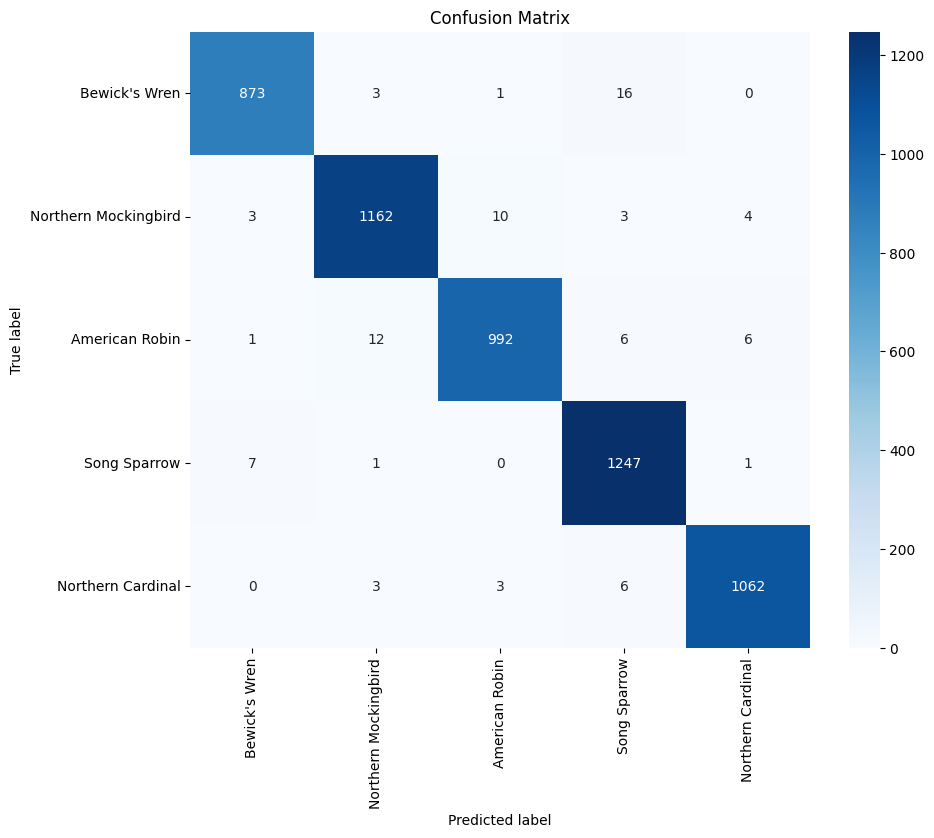

In [11]:
# Générer une matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

# Obtenir les prédictions
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)

# Générer la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
# Calculer le nombre total de faux positifs
false_positives = cm.sum(axis=0) - np.diag(cm)
total_false_positives = false_positives.sum()
print("Nombre total de faux positifs :", total_false_positives)

Nombre total de faux positifs : 86


In [13]:
# Comparer les modèles sauvegardés
from glob import glob

# Récupérer tous les fichiers de modèles
model_files = glob("modeles/*.keras")
model_names = [model.split("/")[-1] for model in model_files]
print("Liste de tous les modèles :", model_names)

# Évaluer chaque modèle
for model_file in model_files:
    temp_model = load_model(model_file)
    temp_predictions = temp_model.predict(test_dataset)
    temp_predicted_classes = np.argmax(temp_predictions, axis=1)
    temp_cm = confusion_matrix(true_classes, temp_predicted_classes)
    temp_false_positives = temp_cm.sum(axis=0) - np.diag(temp_cm)
    print(f"Modèle : {model_file}, Nombre total de faux positifs : {temp_false_positives.sum()}")

Liste de tous les modèles : ['modeles\\saved_model.keras', 'modeles\\model97.keras', 'modeles\\model83.keras', 'modeles\\model82.keras', 'modeles\\model84.keras', 'modeles\\model_over.keras', 'modeles\\model_test_L.keras']
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step
Modèle : modeles\saved_model.keras, Nombre total de faux positifs : 86
Modèle : modeles\saved_model.keras, Nombre total de faux positifs : 86
  4/543 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step 

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
Modèle : modeles\model97.keras, Nombre total de faux positifs : 159
Modèle : modeles\model97.keras, Nombre total de faux positifs : 159
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
Modèle : modeles\model83.keras, Nombre total de faux positifs : 197
Modèle : modeles\model83.keras, Nombre total de faux positifs : 197
543/543 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
Modèle : modeles\model82.keras, Nombre total de faux positifs : 836
Modèle : modeles\model82.keras, Nombre total de faux positifs : 836
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
Modèle : modeles\model84.keras, Nombre total de faux positifs : 167
Modèle : modeles\model84.keras, Nombre total de faux positifs : 167
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
Modèle : modeles\model_over.keras, N